# L2A GRS image
Simple example to open and visualize L2A GRS image

In [1]:

import os, glob

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr
import rioxarray as rio
import cartopy.crs as ccrs

opj = os.path.join


## Open and check

In [2]:
file = '/data/satellite/Sentinel-2/L2A/31TFJ/2021/08/20/S2A_MSIL2Agrs_20210820T104021_N0500_R008_T31TFJ_20230122T133008/S2A_MSIL2Agrs_20210820T104021_N0500_R008_T31TFJ_20230122T133008.nc'
l2a = xr.open_dataset(file,decode_coords='all')
l2a

<xarray.Dataset> Size: 4GB
Dimensions:             (wl: 11, y: 5490, x: 5490)
Coordinates:
  * wl                  (wl) int64 88B 443 490 560 665 705 ... 842 865 1610 2190
    time                datetime64[ns] 8B ...
  * x                   (x) float64 44kB 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                   (y) float64 44kB 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    central_wavelength  (wl) float32 44B ...
    band                int64 8B ...
    spatial_ref         int64 8B ...
Data variables:
    Rrs                 (wl, y, x) float64 3GB ...
    BRDFg               (y, x) float64 241MB ...
    aot550              (y, x) float64 241MB ...
    mask                (y, x) uint8 30MB ...
    vza                 (y, x) float64 241MB ...
    sza                 (y, x) float64 241MB ...
    raa                 (y, x) float64 241MB ...
    flags               (y, x) int64 241MB ...
    dem                 (y, x) float64 241MB ...
Attributes: (12/72)
    long_name:                           CA BLUE GREEN RED VRE_1 VRE_2 VRE_3 ...
    constellation:                       Sentinel-2
    constellation_id:                    S2
    product_path:                        /data/satellite/Sentinel-2/L1C/31TFJ...
    product_name:                        S2A_MSIL1C_20210820T104021_N0500_R00...
    product_filename:                    S2A_MSIL1C_20210820T104021_N0500_R00...
    ...                                  ...
    vis_swir_index_threshold:            0.0
    hcld_threshold:                      0.003
    dirdata:                             /data/grs/grsdata
    abs_gas_file:                        /home/harmel/Dropbox/Dropbox/work/gi...
    water_vapor_transmittance_file:      /home/harmel/Dropbox/Dropbox/work/gi...
    metadata_profile:                    datacube

## Geoinformation and plotting
You can get the projection information and then plot the RGB image as follows:

In [3]:
str_epsg = str(l2a.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

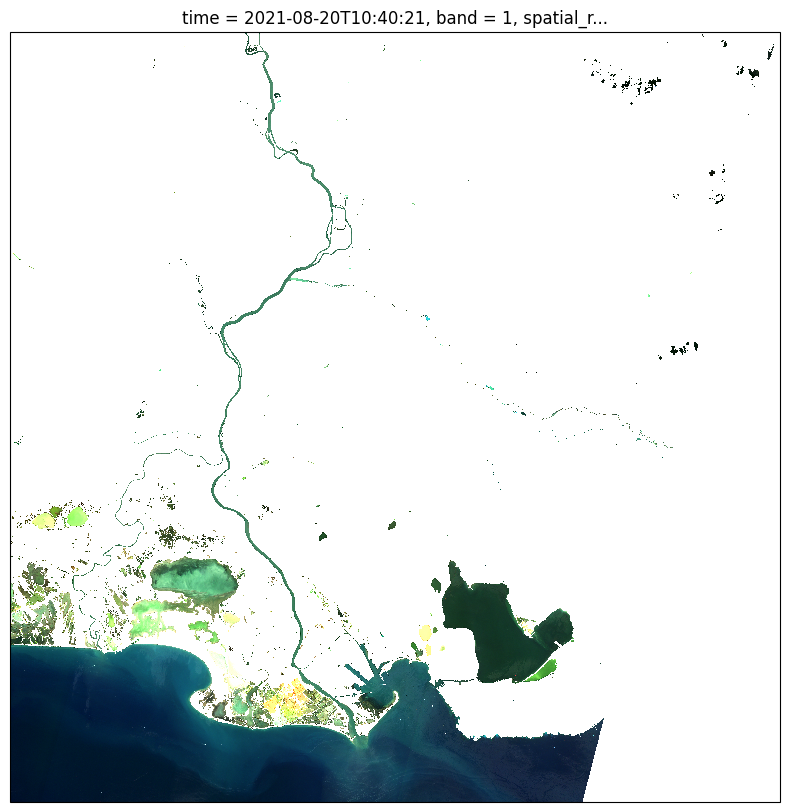

In [4]:
plt.figure(figsize=(10,10))
l2a.Rrs.sel(wl=[665,560,490]).where(l2a.mask==0).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

## Reprojection
If you want to reproject in EPSG:4326 Geodetic coordinate system for World (not recommended)

In [5]:
l2a_reproj = l2a.rio.reproject(4326)
l2a_reproj

<xarray.Dataset> Size: 4GB
Dimensions:             (x: 6477, y: 4695, wl: 11)
Coordinates:
  * x                   (x) float64 52kB 4.232 4.232 4.233 ... 5.626 5.626 5.626
  * y                   (y) float64 38kB 44.25 44.25 44.25 ... 43.24 43.24 43.24
  * wl                  (wl) int64 88B 443 490 560 665 705 ... 842 865 1610 2190
    band                int64 8B 1
    central_wavelength  (wl) float32 44B 442.7 492.7 ... 1.614e+03 2.202e+03
    time                datetime64[ns] 8B 2021-08-20T10:40:21
    spatial_ref         int64 8B 0
Data variables:
    Rrs                 (wl, y, x) float64 3GB nan nan nan nan ... nan nan nan
    BRDFg               (y, x) float64 243MB nan nan nan nan ... nan nan nan nan
    aot550              (y, x) float64 243MB nan nan nan nan ... nan nan nan nan
    mask                (y, x) uint8 30MB 255 255 255 255 ... 255 255 255 255
    vza                 (y, x) float64 243MB nan nan nan nan ... nan nan nan nan
    sza                 (y, x) float64 243MB nan nan nan nan ... nan nan nan nan
    raa                 (y, x) float64 243MB nan nan nan nan ... nan nan nan nan
    flags               (y, x) int64 243MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    dem                 (y, x) float64 243MB nan nan nan nan ... nan nan nan nan
Attributes: (12/72)
    long_name:                           CA BLUE GREEN RED VRE_1 VRE_2 VRE_3 ...
    constellation:                       Sentinel-2
    constellation_id:                    S2
    product_path:                        /data/satellite/Sentinel-2/L1C/31TFJ...
    product_name:                        S2A_MSIL1C_20210820T104021_N0500_R00...
    product_filename:                    S2A_MSIL1C_20210820T104021_N0500_R00...
    ...                                  ...
    vis_swir_index_threshold:            0.0
    hcld_threshold:                      0.003
    dirdata:                             /data/grs/grsdata
    abs_gas_file:                        /home/harmel/Dropbox/Dropbox/work/gi...
    water_vapor_transmittance_file:      /home/harmel/Dropbox/Dropbox/work/gi...
    metadata_profile:                    datacube


## Subset with projected coordinates
The easiest and fastest way to extract from lon/lat coordinates is to convert the lon/lat bounds into the projected coordinates in the geographic system of your image:


In [6]:
from pyproj import CRS, Transformer

lonmin,lonmax=4.92,5.3
latmin,latmax=43.6,43.35

in_crs = CRS.from_epsg(4326)
out_crs = CRS.from_epsg(l2a.rio.crs.to_epsg())

transform = Transformer.from_crs(in_crs, out_crs, always_xy=True)
minx,miny = transform.transform(lonmin, latmax)
maxx,maxy = transform.transform(lonmax, latmin)

l2a_subset = l2a.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy)
l2a_subset

<xarray.Dataset> Size: 311MB
Dimensions:             (wl: 11, x: 1502, y: 1428)
Coordinates:
  * wl                  (wl) int64 88B 443 490 560 665 705 ... 842 865 1610 2190
    time                datetime64[ns] 8B 2021-08-20T10:40:21
  * x                   (x) float64 12kB 6.556e+05 6.556e+05 ... 6.856e+05
  * y                   (y) float64 11kB 4.83e+06 4.83e+06 ... 4.801e+06
    central_wavelength  (wl) float32 44B 442.7 492.7 ... 1.614e+03 2.202e+03
    band                int64 8B 1
    spatial_ref         int64 8B 0
Data variables:
    Rrs                 (wl, y, x) float64 189MB nan nan nan nan ... nan nan nan
    BRDFg               (y, x) float64 17MB nan nan nan nan ... nan nan nan nan
    aot550              (y, x) float64 17MB 0.152 0.152 0.152 ... 0.172 0.172
    mask                (y, x) uint8 2MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    vza                 (y, x) float64 17MB 9.11 9.11 9.11 9.11 ... nan nan nan
    sza                 (y, x) float64 17MB nan nan nan nan ... nan nan nan nan
    raa                 (y, x) float64 17MB 122.8 122.8 122.8 ... nan nan nan
    flags               (y, x) int64 17MB 512 512 512 512 ... 513 513 513 513
    dem                 (y, x) float64 17MB 46.0 46.0 45.0 45.0 ... 0.0 0.0 0.0
Attributes: (12/72)
    long_name:                           CA BLUE GREEN RED VRE_1 VRE_2 VRE_3 ...
    constellation:                       Sentinel-2
    constellation_id:                    S2
    product_path:                        /data/satellite/Sentinel-2/L1C/31TFJ...
    product_name:                        S2A_MSIL1C_20210820T104021_N0500_R00...
    product_filename:                    S2A_MSIL1C_20210820T104021_N0500_R00...
    ...                                  ...
    vis_swir_index_threshold:            0.0
    hcld_threshold:                      0.003
    dirdata:                             /data/grs/grsdata
    abs_gas_file:                        /home/harmel/Dropbox/Dropbox/work/gi...
    water_vapor_transmittance_file:      /home/harmel/Dropbox/Dropbox/work/gi...
    metadata_profile:                    datacube

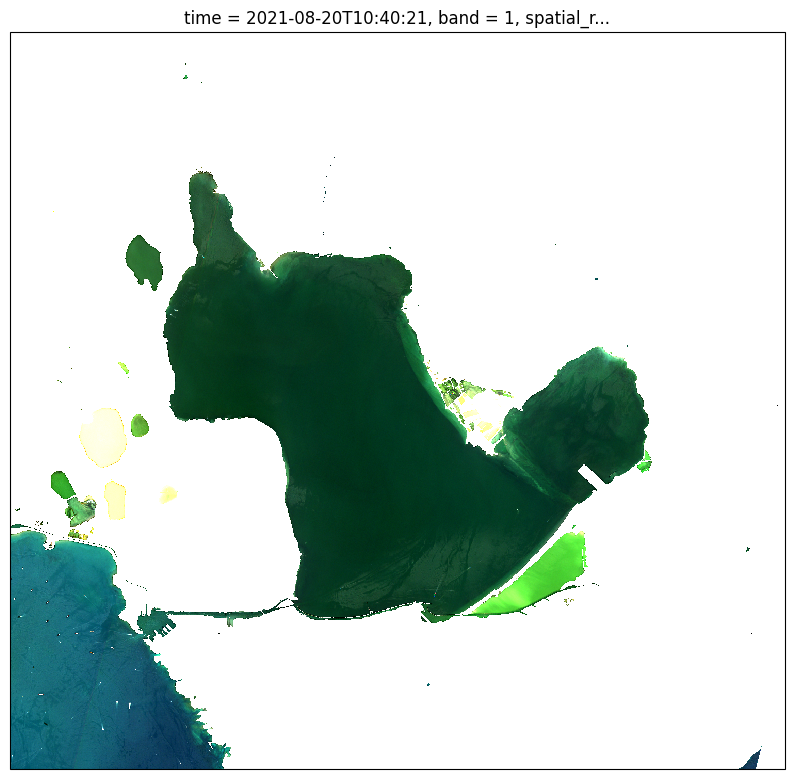

In [7]:
plt.figure(figsize=(10,10))
l2a_subset.Rrs.sel(wl=[665,560,490]).where(l2a_subset.mask==0).plot.imshow(rgb='wl',
                                                                           robust=True,
                                                                           subplot_kws=dict(projection=proj))


## GRStbx
Otherwise, I might be interested in using GRSTBX (https://github.com/Tristanovsk/grstbx) that provides the tools for subsettint and visualizing temporal datacubes

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
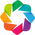

In [14]:
import grstbx
from grstbx import visual
import geopandas as gpd
import holoviews as hv
hv.extension('bokeh')


In [9]:

v=visual.ViewSpectral(l2a.Rrs,reproject=True)

The next cell will render the visualization tool. For subsetting, you can choose the polygon drawer tool on the right side and then press long to generate the polygon. Short clicks will add a new segment and long click end the polygon.

In [10]:
v.visu()


Column
    [0] WidgetBox
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[0, 1, 2, 3, 4, ...], value=2)
            [1] Row
                [0] Row
                    [0] Markdown(str)
                    [1] DatePicker(enabled_dates=[datetime.date(2021, ...], start=datetime.date(2021, ..., value=datetime.date(2021, ...)
                [1] Row
                    [0] Markdown(str)
                    [1] Select(options=['CartoDark', ...], value='CartoDark')
            [2] Row
                [0] Row
                    [0] Markdown(str)
                    [1] EditableRangeSlider(end=0.06, name='Range Slider', step=0.0001, value=(0, 0.02), width=300)
                [1] Row
                    [0] Markdown(str)
                    [1] FloatSlider(name='Opacity', step=0.05, value=0.95)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CET_D13', 'bky', ...], value='CET_D13')
        [2] HoloViews(DynamicMap, height=800, sizing_mode='fixed', width=1200)

The next cell was commented for rendendering in Readthedocs (please uncomment for proper use of the notebook)

In [11]:
#geom_ = v.get_geom(v.aoi_stream,crs=l2a.rio.crs)
#geom_.to_file("roi_grs_visu_simple.json", driver="GeoJSON")

In [15]:
geom_ = gpd.read_file("roi_grs_visu_simple.json", driver="GeoJSON")
Rrs_clipped = l2a.Rrs.sel(wl=slice(400,1000)).where(l2a.mask==0).rio.clip(geom_.geometry.values)

/home/harmel/anaconda3/envs/py12/lib/python3.12/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


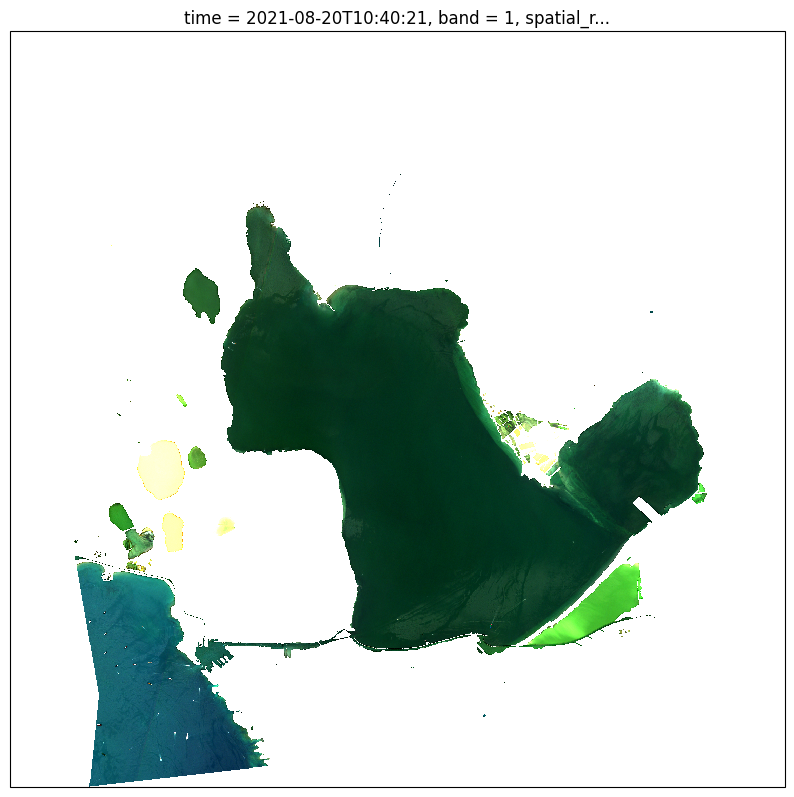

In [16]:
plt.figure(figsize=(10,10))
Rrs_clipped.sel(wl=[665,560,490]).plot.imshow(rgb='wl',
                                              robust=True,
                                              subplot_kws=dict(projection=proj))

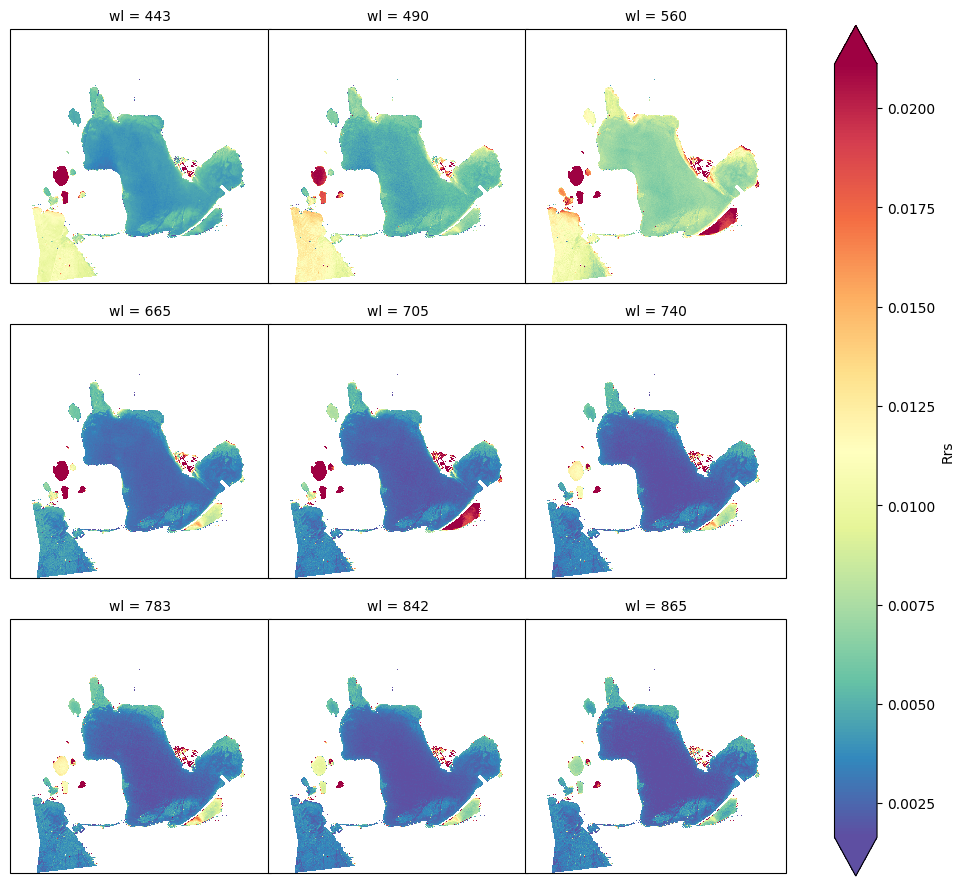

In [17]:
Rrs_clipped.plot.imshow(col='wl',col_wrap=3, robust=True, cmap=plt.cm.Spectral_r,
                                              subplot_kws=dict(projection=proj))